In [92]:
import matplotlib.pyplot as plt
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
# Library imports
import pyforest
import struct
import skimage.transform
import tensorflow as tf
import datetime

# Dependency imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Notebook Extentions
%load_ext tensorboard

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Japanese Handwriting Recognition Project

![Japanese_Kana_Chart](img/variant-hentaigana-chart.jpg)

## Agenda

This project aims to accurately predict Japanese handwriting and display the corresponding text output correctly. Using the three main Japanese language writing systems (Kanji, Hiragana, Katakana), the data is from the [ETL Character Database](http://etlcdb.db.aist.go.jp/), which includes over a billion total of Japanese characters hand-written and reorganized by the [National Institute of Advanced Industrial Science and Technology (AIST)](http://www.jeita.or.jp/english/). 

## Data Information

- Each file contains 5 data sets except ETL8G_33
- Each data set contains 956 characters written by a writer.
- Each writer wrote 10 sheets (genkouyoushi) per data set

### Japanese Character Dataset Info

- **Hiragana (ETL 8)**
    - 71 hiragana characters (46 unique + 29 diphthongs)
    - 160 writers
    - 8199 records (genkouyoushi sheets) 
    - 1,254,120,000 unique handwritten hiragana characters (shared with kanji chars in the same files)
- **Kanji (ETL 8)**
    - 883 daily use kanji
    - 160 writers
    - 8199 records 
    - 152,878,411 unique handwritten kanji (shared with hiragana chars in the same files)
- **Katakana (ETL 1)**
    - 46 katakana characters (46 unique, dipthongs not included as they are phonetically identical to hiragana)
    - 1411 writers
    - 2052 records
    - 2,436,366 unique handwritten katakana characters

### Import & Read Hiragana

In [2]:
hira_kanji_record = 8199

In [3]:
# Reading the Hiragana ETL8G File
def read_ETL8G(f):
    s = f.read(hira_kanji_record)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [4]:
# Function to read the binary code present in each of the 33 files included in the ETL8G folder
def read_hiragana():
    # Characters = 71, writers = 160, y = 127, x = 128
    hiragana = np.zeros([71, 160, 127, 128], dtype = np.uint8)

    for j in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(5):
                moji = 0
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hiragana[moji, (j - 1) * 5 + id_dataset] = np.array(r[-1])
                            moji += 1
    np.savez_compressed('data/hiragana.npz', hiragana)

In [5]:
# Running the Function Above
# read_hiragana()

In [6]:
hiragana_data = np.load('data/hiragana.npz')
hira_test = hiragana_data.f.arr_0

In [7]:
hira_test.shape

(71, 160, 127, 128)

### Import & Read Kanji

In [8]:
def read_kanji():
    # Characters = 883, writers = 160, y = 127, x = 128
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed('data/kanji.npz', kanji)

In [ ]:
# read_kanji()

In [9]:
kanji_data = np.load('data/kanji.npz')
kanji_test = kanji_data.f.arr_0

In [10]:
kanji_test.shape

(883, 160, 127, 128)

### Import & Read Katakana

In [11]:
kana_record = 2052

In [12]:
# Reading in the Katakana ETL1 File
def read_ETL1(total_sheets, f):
    s = f.read(kana_record)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [13]:
def read_katakana():
    # Character type = 46, writers = 1411, y = 63, x = 64
    katakana = np.zeros([46, 1411, 63, 64], dtype=np.uint8)
    counter = 0
    moji = 0
    for k in range(7, 14):
        filename = 'data/ETL1/ETL1C_{:02d}'.format(k)
        with open(filename, 'rb') as f:
            total_sheets = 0
            categories = 8
            if k == 13:
                categories = 3
            for j in range(categories):
                incrimenter = 0
                person = 0
                sheets = 1411
                if k == 9 and j == 4:
                    sheets = 1410
                elif k == 12 and j == 1:
                    sheets = 1410
                for i in range(sheets):
                    r = read_ETL1(total_sheets, f)
                    total_sheets += sheets
                    if k < 11 or (k >= 11 and b' I' not in r[1] and b' E' not in r[1] and b'WI' not in r[1] and b' U' not in r[1] and b'WE' not in r[1]):
                        pixels = np.array(r[-1])
                        for row in pixels:
                            for i in range(len(row)):
                                if row[i] == 1 or row[i] == 2:
                                    row[i] = 0
                        katakana[moji, person] = pixels
                        incrimenter = 1
                        person += 1
                moji += incrimenter
    np.savez_compressed('data/katakana.npz', katakana)

In [14]:
# read_katakana()

In [15]:
katakana_data = np.load('data/katakana.npz')
kana_test = katakana_data.f.arr_0

In [16]:
kana_test.shape

(46, 1411, 63, 64)

## Visualizing Characters

### Visualizing Hiragana

In [17]:
# Visualizing Hiragana
def visualize_hiragana():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2]:
                        print(r[:4])

In [18]:
visualize_hiragana()

(1, 9250, b'A.HIRA  ', 1)
(1, 9252, b'I.HIRA  ', 16)
(1, 9254, b'U.HIRA  ', 31)
(1, 9256, b'E.HIRA  ', 46)
(1, 9258, b'O.HIRA  ', 61)
(1, 9259, b'KA.HIRA ', 76)
(1, 19007, b'HEI.HIRA', 83)
(1, 9260, b'GA.HIRA ', 91)
(2, 9261, b'KI.HIRA ', 1)
(2, 9262, b'GI.HIRA ', 16)
(2, 9263, b'KU.HIRA ', 31)
(2, 9264, b'GU.HIRA ', 46)
(2, 9265, b'KE.HIRA ', 61)
(2, 9266, b'GE.HIRA ', 76)
(2, 9267, b'KO.HIRA ', 91)
(3, 9268, b'GO.HIRA ', 193)
(3, 9269, b'SA.HIRA ', 208)
(3, 9270, b'ZA.HIRA ', 223)
(3, 9271, b'SHI.HIRA', 238)
(3, 9272, b'JI.HIRA ', 253)
(3, 9273, b'SU.HIRA ', 268)
(3, 9274, b'ZU.HIRA ', 283)
(4, 9275, b'SE.HIRA ', 289)
(4, 9276, b'ZE.HIRA ', 304)
(4, 9277, b'SO.HIRA ', 319)
(4, 9278, b'ZO.HIRA ', 334)
(4, 9279, b'TA.HIRA ', 349)
(4, 9280, b'DA.HIRA ', 364)
(4, 9281, b'CHI.HIRA', 378)
(5, 9282, b'JI.HIRA ', 385)
(5, 9284, b'TSU.HIRA', 400)
(5, 9285, b'ZU.HIRA ', 415)
(5, 9286, b'TE.HIRA ', 430)
(5, 9287, b'DE.HIRA ', 445)
(5, 9288, b'TO.HIRA ', 460)
(5, 9289, b'DO.HIRA ', 475)
(6, 9290

In [19]:
def one_kana():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if b'.WO.' in r[2]:
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'kana_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [20]:
one_kana()

- Kana Sample Visualization ![kana](img/kana_visualization.png)

### Visualizing Kanji

In [ ]:
def visualize_kanji():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                        print(r[:4])

In [ ]:
visualize_kanji()

In [21]:
def one_kanji():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'kanji_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [22]:
one_kanji()

- Kanji Sample Visualization: ![kanji](img/kanji_visualization.png)

## Feature Engineering

- The image dimensions need to be resized for the ML model to work on them. Initially images were resized to 32x32, but due to model performance, they were upsized to be 48x48.

### Resizing Hiragana Images

In [3]:
# 71 unique classes of hiragana (including dipthongs)
hiragana_class = 71

# Image dimensions
img_row, img_col = 48, 48

In [4]:
hiragana_table = np.load('data/hiragana.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
hiragana_table = hiragana_table/np.max(hiragana_table)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
hiragana_train = np.zeros([hiragana_class * 160, img_row, img_col], dtype = np.float32)

for i in range(hiragana_class * 160):
    hiragana_train[i] = skimage.transform.resize(hiragana_table[i], (img_row, img_col))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Resizing Kanji Images

In [6]:
# 879 unique classes of kanji (most daily used kanji)
kanji_class = 873

In [7]:
kanji_table = np.load('data/kanji.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
kanji_table = kanji_table/np.max(kanji_table)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- The kanji and hiragana characters share the ECT8 dataset, and they are not intuitively arranged. This accounts for this so hiragana are not mistakenly classified as kanji characters.

In [8]:
kanji_train = np.zeros([kanji_class * 160, img_row, img_col], dtype = np.float32)

for i in range((kanji_class + 4) * 160):
    if int(i / 160) != 88 and int( i / 160) != 219 and int( i / 160) != 349 and int( i / 160) != 457:
        if int(i / 160) < 88:
            kanji_train[i] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 88 and int(i/160) < 219:
            kanji_train[i-160] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 219 and int(i/160) < 349:
            kanji_train[i-320] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i/160) > 349 and int(i/160) < 457:
            if int(i/160) > 457:
                kanji_train[i-640] = skimage.transform.resize(kanji_table[i], (img_row, img_col))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Resizing Katakana Images

In [9]:
# 71 frequently used katakana characters (including dipthongs)
katakana_class = 46

In [10]:
katakana_table = np.load('data/katakana.npz')['arr_0'].reshape([-1, 63, 64]).astype(np.float32)
katakana_table = katakana_table/np.max(katakana_table)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
katakana_train = np.zeros([katakana_class * 1411, img_row, img_col], dtype = np.float32)

for i in range(katakana_class * 1411):
    katakana_train[i] = skimage.transform.resize(katakana_table[i], (img_row, img_col))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Preparation

### Creating Labels

In [12]:
y_labels_hiragana = np.repeat(np.arange(hiragana_class), 160)
y_labels_kanji = np.repeat(np.arange(kanji_class), 160)
y_labels_katakana = np.repeat(np.arange(katakana_class), 1411)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Train-Test Split

#### Hiragana Train-Test Split

In [13]:
hiragana_train, hiragana_test, hiragana_labels, hiragana_test_labels = train_test_split(
                                                    hiragana_train,
                                                    y_labels_hiragana,
                                                    random_state=42,
                                                    test_size=0.2)

#### Kanji Train-Test Split

In [14]:
kanji_train, kanji_test, kanji_labels, kanji_test_labels = train_test_split(
                                                    kanji_train,
                                                    y_labels_kanji,
                                                    random_state=42,
                                                    test_size=0.3)

#### Katakana Train-Test Split

In [15]:
katakana_train, katakana_test, katakana_labels, katakana_test_labels = train_test_split(
                                                    katakana_train,
                                                    y_labels_katakana,
                                                    random_state=42,
                                                    test_size=0.2)

### Multiclass Classification

- For classification of multiple input types and target variables, we need to create a cross-validation set as well as OneHotEncode our y values (y_train, y_test, y_val)
- We will divide our X values by the number of classes to normalize our pixel values to be between 0 & 1

#### Hiragana Multiclass Preparation

In [16]:
# Labels are our y values

hira_X_train, hira_X_val, hira_y_train, hira_y_val =\
    train_test_split(hiragana_train, hiragana_labels, random_state = 42, test_size = 0.2)

hira_X_train, hira_X_val, hira_X_test = hira_X_train/np.max(hira_X_train), hira_X_val/np.max(hira_X_val),\
                                        hiragana_test/np.max(hiragana_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [95]:
hira_X_train.shape

(7270, 48, 48, 1)

In [96]:
hira_X_val.shape

(1818, 48, 48, 1)

In [18]:
# One Hot Encode our y values. Fit & transform on y train and only transform on our CV and test data.

hiragana_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
hira_y_train = hiragana_ohe.fit_transform(hira_y_train.reshape(-1, 1))
hira_y_val = hiragana_ohe.transform(hira_y_val.reshape(-1, 1))
hira_y_test = hiragana_ohe.transform(hiragana_test_labels.reshape(-1, 1))

#### Kanji Multiclass Preparation

In [19]:
# Labels are our y values

kanji_X_train, kanji_X_val, kanji_y_train, kanji_y_val =\
    train_test_split(kanji_train, kanji_labels, random_state = 42, test_size = 0.3)

kanji_X_train, kanji_X_val, kanji_X_test = kanji_X_train/np.max(kanji_X_train), kanji_X_val/np.max(kanji_X_val),\
                                           kanji_test/np.max(kanji_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
kanji_X_train.shape

(68443, 48, 48, 1)

In [98]:
kanji_X_val.shape

(29333, 48, 48, 1)

In [24]:
# One Hot Encode our y values. Fit & transform on y train and only transform on our CV and test data.

kanji_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
kanji_y_train = kanji_ohe.fit_transform(kanji_y_train.reshape(-1, 1))
kanji_y_val = kanji_ohe.transform(kanji_y_val.reshape(-1, 1))
kanji_y_test = kanji_ohe.transform(kanji_test_labels.reshape(-1, 1))

#### Katakana Multiclass Preparation

In [25]:
# Labels are our y values

katakana_X_train, katakana_X_val, katakana_y_train, katakana_y_val =\
    train_test_split(katakana_train, katakana_labels, random_state = 42, test_size = 0.2)

katakana_X_train, katakana_X_val, katakana_X_test = katakana_X_train/np.max(katakana_X_train),\
                                                katakana_X_val/np.max(katakana_X_val), katakana_test/np.max(katakana_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# One Hot Encode our y values. Fit & transform on y train and only transform on our CV and test data.

katakana_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
katakana_y_train = katakana_ohe.fit_transform(katakana_y_train.reshape(-1, 1))
katakana_y_val = katakana_ohe.transform(katakana_y_val.reshape(-1, 1))
katakana_y_test = katakana_ohe.transform(katakana_test_labels.reshape(-1, 1))

### Adding Variation with ImageDataGenerator

- Tensorflow's ImageDataGenerator can augment images to create new vesions of the data, essentially artificially inserting variation into the data
- Images can be rotated, zoomed, and flipped
- This variation is used to avoid overfitting on the training set
- Following augmentation is for a 2D CNN

#### Hiragana Augmentation

In [27]:
# Default shape for CNN is 'channels_last', this makes sure everything is in the right order

if K.image_data_format() == 'channels_first':
    hira_X_train = hira_X_train.reshape(hira_X_train.shape[0], 1, img_row, img_col)
    hira_X_test = hira_X_test.reshape(hira_X_test.shape[0], 1, img_row, img_col)
    hira_X_val = hira_X_val.reshape(hira_X_val.shape[0], 1, img_row, img_col)
    hira_shape = (1, img_row, img_col) 
else:
    hira_X_train = hira_X_train.reshape(hira_X_train.shape[0], img_row, img_col, 1)
    hira_X_test = hira_X_test.reshape(hira_X_test.shape[0], img_row, img_col, 1)
    hira_X_val = hira_X_val.reshape(hira_X_val.shape[0], img_row, img_col, 1)
    hira_shape = (img_row, img_col, 1) # For CNN

hiragana_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.2)

hiragana_datagen.fit(hira_X_train)

In [99]:
hira_X_train.shape

(7270, 48, 48, 1)

In [100]:
hira_X_val.shape

(1818, 48, 48, 1)

#### Kanji Augmentation

In [30]:
# Default shape for CNN is 'channels_last', this makes sure everything is in the right order

if K.image_data_format() == 'channels_first':
    kanji_X_train = kanji_X_train.reshape(kanji_X_train.shape[0], 1, img_row, img_col)
    kanji_X_test = kanji_X_test.reshape(kanji_X_test.shape[0], 1, img_row, img_col)
    kanji_X_val = kanji_X_val.reshape(kanji_X_val.shape[0], 1, img_row, img_col)
    kanji_shape = (1, img_row, img_col) 
else:
    kanji_X_train = kanji_X_train.reshape(kanji_X_train.shape[0], img_row, img_col, 1)
    kanji_X_test = kanji_X_test.reshape(kanji_X_test.shape[0], img_row, img_col, 1)
    kanji_X_val = kanji_X_val.reshape(kanji_X_val.shape[0], img_row, img_col, 1)
    kanji_shape = (img_row, img_col, 1) # For CNN

kanji_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.2)

kanji_datagen.fit(kanji_X_train)

In [101]:
kanji_X_train.shape

(68443, 48, 48, 1)

In [102]:
kanji_X_val.shape

(29333, 48, 48, 1)

#### Katakana Augmentation

In [33]:
# Default shape for CNN is 'channels_last', this makes sure everything is in the right order

if K.image_data_format() == 'channels_first':
    katakana_X_train = katakana_X_train.reshape(katakana_X_train.shape[0], 1, img_row, img_col)
    katakana_X_test = katakana_X_test.reshape(katakana_X_test.shape[0], 1, img_row, img_col)
    katakana_X_val = katakana_X_val.reshape(katakana_X_val.shape[0], 1, img_row, img_col)
    katakana_shape = (1, img_row, img_col) 
else:
    katakana_X_train = katakana_X_train.reshape(katakana_X_train.shape[0], img_row, img_col, 1)
    katakana_X_test = katakana_X_test.reshape(katakana_X_test.shape[0], img_row, img_col, 1)
    katakana_X_val = katakana_X_val.reshape(katakana_X_val.shape[0], img_row, img_col, 1)
    katakana_shape = (img_row, img_col, 1) # For CNN

katakana_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.2)

katakana_datagen.fit(katakana_X_train)

In [103]:
katakana_X_train.shape

(41539, 48, 48, 1)

In [104]:
katakana_X_val.shape

(10385, 48, 48, 1)

## Final Visualization Tables

- Checking that our finalized data was extracted and correctly, and is readable in the correct visual format.

### Hiragana Table

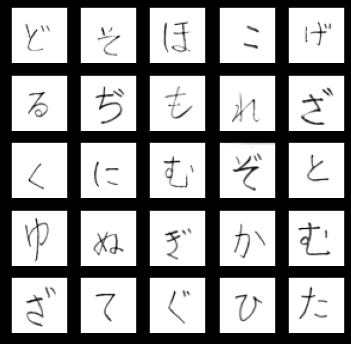

In [54]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(hira_X_train[i], cmap = plt.cm.binary)
plt.show();

### Kanji Table

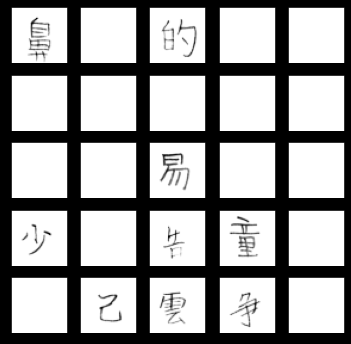

In [158]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kanji_X_train[i], cmap = plt.cm.binary)
plt.show();

### Katakana Table

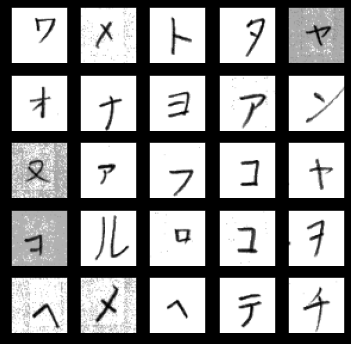

In [56]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(katakana_X_train[i], cmap = plt.cm.binary)
plt.show();

## Modeling

### Hiragana CNN

#### Hiragana CNN Prep

In [37]:
hira_model = models.Sequential()

hira_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = hira_shape, data_format = 'channels_last'))
hira_model.add(layers.MaxPooling2D((2, 2)))
hira_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
hira_model.add(Dropout(0.2))

hira_model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
hira_model.add(layers.MaxPooling2D((2, 2)))
hira_model.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
hira_model.add(Dropout(0.2))

hira_model.add(Flatten())
hira_model.add(Dense(256, activation = 'relu'))
hira_model.add(Dropout(0.2))
hira_model.add(Dense(hiragana_class, activation = 'softmax'))

In [38]:
hira_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       7

In [44]:
# Callbacks
hira_es = EarlyStopping(patience = 5, verbose = 1, restore_best_weights = True)
hira_lr = ReduceLROnPlateau(factor = 0.5, patience = 3, verbose = 1)

# Tensorboard Callback
hira_log_dir = 'logs/hiragana/' + datetime.datetime.now().strftime('Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = hira_log_dir, histogram_freq = 1)

In [45]:
hira_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

hiragana_results = hira_model.fit(hiragana_datagen.flow(hira_X_train, hira_y_train, batch_size = 32),
          epochs = 30, callbacks = (hira_es, hira_lr, tensorboard_callback), validation_data = (hira_X_val, hira_y_val))

Epoch 1/30
228/228 [==============================] - 21s 91ms/step - loss: 0.4894 - accuracy: 0.8546 - val_loss: 0.2191 - val_accuracy: 0.9345
Epoch 2/30
228/228 [==============================] - 20s 87ms/step - loss: 0.3745 - accuracy: 0.8810 - val_loss: 0.2003 - val_accuracy: 0.9373
Epoch 3/30
228/228 [==============================] - 20s 88ms/step - loss: 0.2992 - accuracy: 0.9081 - val_loss: 0.1563 - val_accuracy: 0.9505
Epoch 4/30
228/228 [==============================] - 20s 87ms/step - loss: 0.2482 - accuracy: 0.9150 - val_loss: 0.1495 - val_accuracy: 0.9571
Epoch 5/30
228/228 [==============================] - 20s 87ms/step - loss: 0.2171 - accuracy: 0.9331 - val_loss: 0.1175 - val_accuracy: 0.9626
Epoch 6/30
228/228 [==============================] - 20s 88ms/step - loss: 0.1790 - accuracy: 0.9410 - val_loss: 0.1379 - val_accuracy: 0.9626
Epoch 7/30
228/228 [==============================] - 20s 87ms/step - loss: 0.1760 - accuracy: 0.9433 - val_loss: 0.2031 - val_accuracy:

#### Hiragana CNN Model Evaluation

In [46]:
hira_history = hiragana_results.history
hira_training_loss = hira_history['loss']
hira_val_loss = hira_history['val_loss']
hira_training_accuracy = hira_history['accuracy']
hira_val_accuracy = hira_history['val_accuracy']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

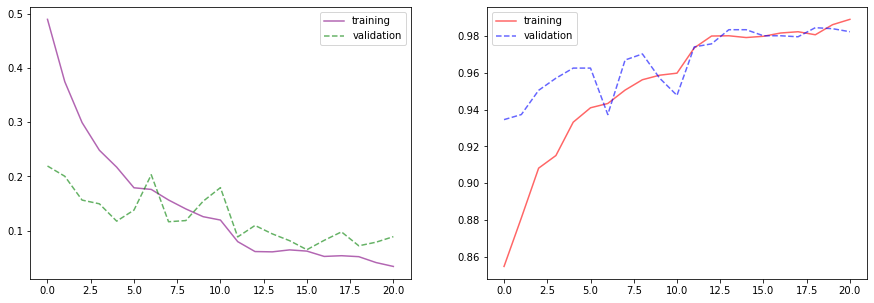

In [84]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x = list(range(len(hira_training_loss))),
             y = hira_training_loss, color = 'purple', alpha = 0.6, label='training', ax = ax1)
sns.lineplot(x = list(range(len(hira_val_loss))),
             y = hira_val_loss, color = 'green', alpha = 0.6, linestyle = 'dashed', label = 'validation', ax = ax1)
sns.lineplot(x = list(range(len(hira_training_loss))),
             y = hira_training_accuracy, color='r', alpha = 0.6, label='training',ax = ax2)
sns.lineplot(x = list(range(len(hira_val_loss))),
             y = hira_val_accuracy, color = 'b', alpha = 0.6, linestyle = 'dashed', label = 'validation',ax = ax2)
# plt.savefig('img/hiragana_loss_acc')
ax1.legend();

#### Hiragana Test Data Results

In [48]:
hira_y_hat_test = np.argmax(hira_model.predict(hira_X_test), axis=-1)
hira_test_restore = hiragana_ohe.inverse_transform(hira_y_test)
confusion_matrix(hira_test_restore, hira_y_hat_test)

<IPython.core.display.Javascript object>

array([[37,  0,  0, ...,  0,  0,  0],
       [ 0, 31,  0, ...,  0,  0,  0],
       [ 0,  0, 36, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 37,  0,  0],
       [ 0,  0,  0, ...,  0, 34,  0],
       [ 0,  0,  0, ...,  0,  0, 40]], dtype=int64)

In [49]:
hira_test_loss, hira_test_acc = hira_model.evaluate(hira_X_test, hira_y_test)

71/71 [==============================] - 1s 16ms/step - loss: 0.0541 - accuracy: 0.9833


In [50]:
print(f'We acheived a test accuracy of {round(hira_test_acc, 4)}% on our Hiragana dataset.')

We acheived a test accuracy of 0.9833% on our Hiragana dataset.


In [53]:
hira_model.save('hiragana_model.h5')

### Kanji CNN

#### Kanji CNN Prep

In [70]:
# Tried a dropout rate of 0.5 to improve the model some. Had slight positive effect

kanji_model = models.Sequential()

kanji_model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = kanji_shape, data_format = 'channels_last'))
kanji_model.add(layers.MaxPooling2D((2, 2)))
kanji_model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
kanji_model.add(layers.MaxPooling2D((2, 2)))
kanji_model.add(layers.Flatten())
kanji_model.add(Dropout(0.5))
kanji_model.add(layers.Dense(2048, activation = 'relu'))
kanji_model.add(layers.Dense(kanji_class, activation = 'softmax'))

In [71]:
kanji_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 9216)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)             

In [72]:
# Callbacks
kanji_es = EarlyStopping(patience = 5, verbose = 1, restore_best_weights = True)
kanji_lr = ReduceLROnPlateau(factor = 0.5, patience = 3, verbose = 1)

# Tensorboard Callback
kanji_log_dir = 'logs/kanji/' + datetime.datetime.now().strftime('Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = kanji_log_dir, histogram_freq = 1)

In [73]:
kanji_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

kanji_results = kanji_model.fit(kanji_datagen.flow(kanji_X_train, kanji_y_train, shuffle = True),
          epochs = 50, callbacks = (kanji_es, kanji_lr, tensorboard_callback), validation_data = (kanji_X_val, kanji_y_val))

Epoch 1/50
2139/2139 [==============================] - 330s 154ms/step - loss: 4.9173 - accuracy: 0.1635 - val_loss: 4.0430 - val_accuracy: 0.3265
Epoch 2/50
2139/2139 [==============================] - 326s 153ms/step - loss: 4.0895 - accuracy: 0.3133 - val_loss: 3.8938 - val_accuracy: 0.3652
Epoch 3/50
2139/2139 [==============================] - 324s 152ms/step - loss: 3.9900 - accuracy: 0.3389 - val_loss: 3.8623 - val_accuracy: 0.3745
Epoch 4/50
2139/2139 [==============================] - 327s 153ms/step - loss: 3.9440 - accuracy: 0.3507 - val_loss: 3.8575 - val_accuracy: 0.3767
Epoch 5/50
2139/2139 [==============================] - 325s 152ms/step - loss: 3.9189 - accuracy: 0.3577 - val_loss: 3.8377 - val_accuracy: 0.3817
Epoch 6/50
2139/2139 [==============================] - 325s 152ms/step - loss: 3.8988 - accuracy: 0.3627 - val_loss: 3.8484 - val_accuracy: 0.3798
Epoch 7/50
2139/2139 [==============================] - 325s 152ms/step - loss: 3.8854 - accuracy: 0.3661 - val_

#### Kanji CNN Model Evaluation

In [74]:
kanji_history = kanji_results.history
kanji_training_loss = kanji_history['loss']
kanji_val_loss = kanji_history['val_loss']
kanji_training_accuracy = kanji_history['accuracy']
kanji_val_accuracy = kanji_history['val_accuracy']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

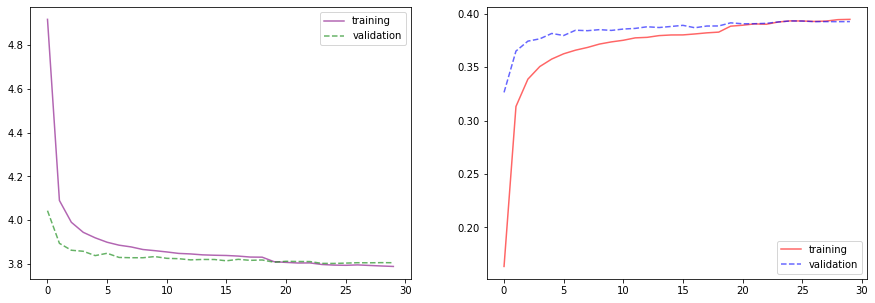

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x = list(range(len(kanji_training_loss))),
             y = kanji_training_loss, color = 'purple', alpha = 0.6, label='training', ax = ax1)
sns.lineplot(x = list(range(len(kanji_val_loss))),
             y = kanji_val_loss, color = 'green', alpha = 0.6, linestyle = 'dashed', label = 'validation', ax = ax1)
sns.lineplot(x = list(range(len(kanji_training_loss))),
             y = kanji_training_accuracy, color='r', alpha = 0.6, label='training',ax = ax2)
sns.lineplot(x = list(range(len(kanji_val_loss))),
             y = kanji_val_accuracy, color = 'b', alpha = 0.6, linestyle = 'dashed', label = 'validation',ax = ax2)
# plt.savefig('img/kanji_loss_acc.png')
ax1.legend();

#### Kanji Test Data Results

In [76]:
kanji_y_hat_test = np.argmax(kanji_model.predict(kanji_X_test), axis=-1)
kanji_test_restore = kanji_ohe.inverse_transform(kanji_y_test)
confusion_matrix(kanji_test_restore, kanji_y_hat_test)

<IPython.core.display.Javascript object>

array([[43,  0,  0, ...,  0,  0,  0],
       [ 0, 45,  0, ...,  0,  0,  0],
       [ 0,  0, 56, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [77]:
kanji_test_loss, kanji_test_acc = kanji_model.evaluate(kanji_X_test, kanji_y_test)

1310/1310 [==============================] - 37s 28ms/step - loss: 3.7919 - accuracy: 0.3944


In [78]:
print(f'We acheived a test accuracy of {round(kanji_test_acc, 4)}% on our Kanji dataset.')

We acheived a test accuracy of 0.3944% on our Kanji dataset.


In [79]:
kanji_model.save('kanji_model.h5')

### Katakana CNN

#### Katakana CNN Prep

In [57]:
katakana_model = models.Sequential()

katakana_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = katakana_shape, data_format = 'channels_last'))
katakana_model.add(layers.MaxPooling2D((2, 2)))
katakana_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
katakana_model.add(Dropout(0.2))

katakana_model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
katakana_model.add(layers.MaxPooling2D((2, 2)))
katakana_model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
katakana_model.add(Dropout(0.2))

katakana_model.add(Flatten())
katakana_model.add(layers.Dense(256, activation = 'relu'))
katakana_model.add(Dropout(0.2))
katakana_model.add(layers.Dense(katakana_class, activation = 'softmax'))

In [58]:
katakana_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 64)       

In [60]:
# Callbacks
katakana_es = EarlyStopping(patience = 5, verbose = 1, restore_best_weights = True)
katakana_lr = ReduceLROnPlateau(factor = 0.5, patience = 3, verbose = 1)

# Tensorboard Callback
katakana_log_dir = 'logs/katakana/' + datetime.datetime.now().strftime('Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = katakana_log_dir, histogram_freq = 1)

In [61]:
katakana_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

katakana_results = katakana_model.fit(katakana_datagen.flow(katakana_X_train, katakana_y_train, batch_size = 32),
          epochs = 30, callbacks = (katakana_es, katakana_lr, tensorboard_callback), validation_data = (katakana_X_val, katakana_y_val))

Epoch 1/30
1299/1299 [==============================] - 98s 75ms/step - loss: 0.9570 - accuracy: 0.7344 - val_loss: 0.1774 - val_accuracy: 0.9549
Epoch 2/30
1299/1299 [==============================] - 96s 74ms/step - loss: 0.3032 - accuracy: 0.9148 - val_loss: 0.1208 - val_accuracy: 0.9714
Epoch 3/30
1299/1299 [==============================] - 95s 73ms/step - loss: 0.2216 - accuracy: 0.9382 - val_loss: 0.1268 - val_accuracy: 0.9672
Epoch 4/30
1299/1299 [==============================] - 97s 74ms/step - loss: 0.1882 - accuracy: 0.9490 - val_loss: 0.0888 - val_accuracy: 0.9801
Epoch 5/30
1299/1299 [==============================] - 96s 74ms/step - loss: 0.1578 - accuracy: 0.9564 - val_loss: 0.0838 - val_accuracy: 0.9815
Epoch 6/30
1299/1299 [==============================] - 95s 74ms/step - loss: 0.1409 - accuracy: 0.9609 - val_loss: 0.0961 - val_accuracy: 0.9763
Epoch 7/30
1299/1299 [==============================] - 95s 73ms/step - loss: 0.1294 - accuracy: 0.9654 - val_loss: 0.0754 -

#### Katakana CNN Model Evaluation

In [63]:
katakana_history = katakana_results.history
katakana_training_loss = katakana_history['loss']
katakana_val_loss = katakana_history['val_loss']
katakana_training_accuracy = katakana_history['accuracy']
katakana_val_accuracy = katakana_history['val_accuracy']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

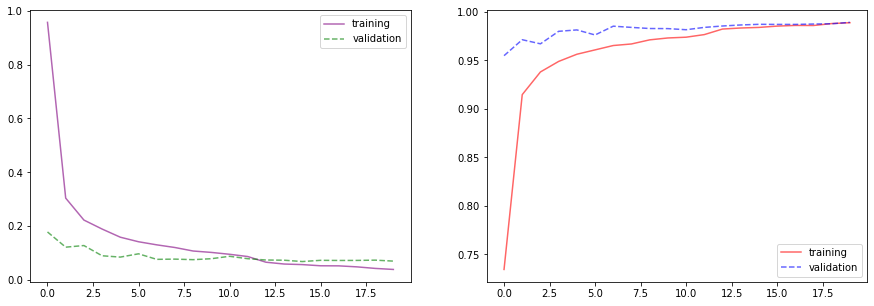

In [85]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x = list(range(len(katakana_training_loss))),
             y = katakana_training_loss, color = 'purple', alpha = 0.6, label = 'training', ax = ax1)
sns.lineplot(x = list(range(len(katakana_val_loss))),
             y = katakana_val_loss, color = 'green', alpha = 0.6, linestyle = 'dashed', label = 'validation', ax = ax1)
sns.lineplot(x = list(range(len(katakana_training_loss))),
             y = katakana_training_accuracy, color = 'r', alpha = 0.6, label = 'training', ax = ax2)
sns.lineplot(x = list(range(len(katakana_val_loss))),
             y = katakana_val_accuracy, color = 'b', alpha = 0.6, linestyle = 'dashed', label = 'validation', ax = ax2)
# plt.savefig('img/katakana_loss_acc.png')
ax1.legend();

#### Katakana Test Data Results

In [66]:
katakana_y_hat_test = np.argmax(katakana_model.predict(katakana_X_test), axis=-1)
katakana_test_restore = katakana_ohe.inverse_transform(katakana_y_test)
confusion_matrix(katakana_test_restore, katakana_y_hat_test)

<IPython.core.display.Javascript object>

array([[285,   0,   0, ...,   0,   0,   0],
       [  0, 265,   0, ...,   0,   0,   0],
       [  0,   0, 290, ...,   2,   0,   0],
       ...,
       [  0,   0,   0, ..., 277,   0,   0],
       [  0,   0,   0, ...,   0, 275,   0],
       [  0,   0,   0, ...,   0,   0, 258]], dtype=int64)

In [67]:
katakana_test_loss, katakana_test_acc = katakana_model.evaluate(katakana_X_test, katakana_y_test)

406/406 [==============================] - 6s 14ms/step - loss: 0.0614 - accuracy: 0.9878


In [68]:
print(f'We acheived a test accuracy of {round(katakana_test_acc, 4)}% on our Katakana dataset.')

We acheived a test accuracy of 0.9878% on our Katakana dataset.


In [69]:
katakana_model.save('katakana_model.h5')

### Tensorboard Visualization

In [94]:
# tensorboard --logdir logs/fit

## Conclusions & Next Steps

### Conclusions:

- Kanji model may be underperforming due to sheer amount of separate classes in the dataset (883)
- Kanji are composed in “parts” called radicals. These radicals are also the basis for many original hiragana & katakana characters
- Less variation in Hiragana and Katakana characters could be why those models performed so well
- Many kanji are quite similar to each other, especially with radicals combinations that express similar ideas. Would be interesting to see the way radicals or structural components of kanji affect the model
- Further upsizing the kanji images to 64x64 or higher may improve the model

### Next Steps:

- Fine tune model params for kanji model to achieve higher accuracy
- Further dive into Tensorboard to view for live modeling (did post model in this notebook)
- Implement cloud-based modeling using other model techniques. Running in the cloud on multiple GPUs will speed up production time and lessen the strain on my work rig
- Combine datasets in the future to work on an image classification model that can identify the type of character (hiragana, katakana, kanji, romanji, numerals) for capstone
- Expand model for touchscreen API integration for language education (iOS app) 